In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
import seaborn as sns
import tensorflow as tf

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random

from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
image_dir = Path('flowers')
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [3]:
image_dir

WindowsPath('flowers')

In [4]:
image_df.head()

,Filepath,Label
0,flowers\daisy\100080576_f52e8ee070_n.jpg,daisy
1,flowers\daisy\10140303196_b88d3d6cec.jpg,daisy
2,flowers\daisy\10172379554_b296050f82_n.jpg,daisy
3,flowers\daisy\10172567486_2748826a8b.jpg,daisy
4,flowers\daisy\10172636503_21bededa75_n.jpg,daisy


In [5]:
image_df = image_df.sample(frac=1).reset_index(drop = True)
image_df.head(12)

,Filepath,Label
0,flowers\daisy\4790631791_21e9648097_n.jpg,daisy
1,flowers\rose\5336559428_71e8b58ab5_n.jpg,rose
2,flowers\tulip\13539827514_79b60b6c22_n.jpg,tulip
3,flowers\dandelion\33886917763_2db539f182_n.jpg,dandelion
4,flowers\rose\475936554_a2b38aaa8e.jpg,rose
5,flowers\rose\5721768347_2ec4d2247b_n.jpg,rose
6,flowers\tulip\20701823522_43e3f4ba09_n.jpg,tulip
7,flowers\daisy\13491959645_2cd9df44d6_n.jpg,daisy
8,flowers\dandelion\34662979916_0479576f5e_n.jpg,dandelion
9,flowers\rose\1813435848_7852708394_n.jpg,rose


In [6]:
image_df.shape

(4317, 2)

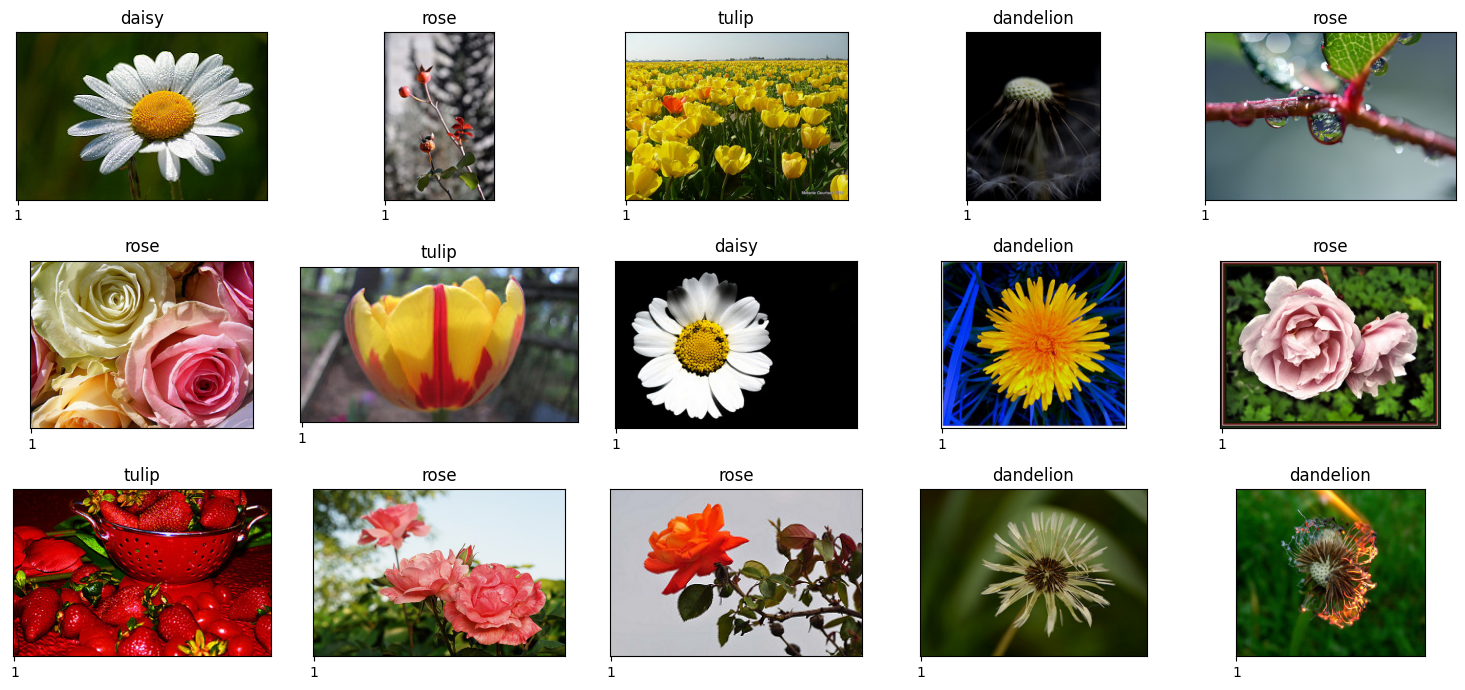

In [7]:
fig,axes=plt.subplots(nrows=3,ncols=5,figsize=(15,7),subplot_kw={'xticks':[1],'yticks':[]})


for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()



In [8]:
train_df ,test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [9]:
train_df.shape

(3453, 2)

In [10]:
test_df.shape

(864, 2)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_df.head()

,Filepath,Label
1338,flowers\rose\5002452834_167883dbcf_n.jpg,rose
2836,flowers\sunflower\8929274876_17efc1774a_n.jpg,sunflower
3378,flowers\sunflower\175638423_058c07afb9.jpg,sunflower
3296,flowers\dandelion\17244252705_328e0bcda6.jpg,dandelion
1459,flowers\sunflower\4080112931_cb20b3d51a_n.jpg,sunflower


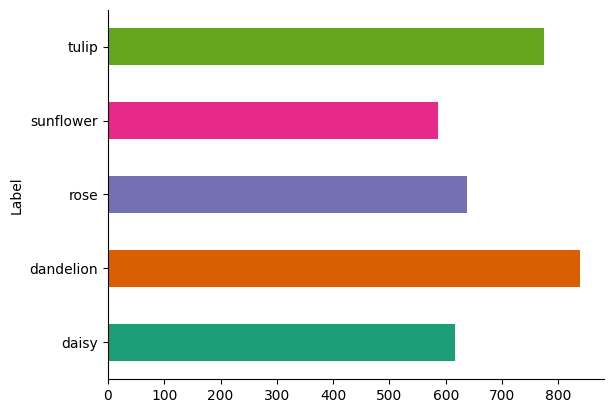

In [13]:
# @title Label
train_df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
train_df.tail()

,Filepath,Label
2895,flowers\rose\7471890786_aaff777641_n.jpg,rose
2763,flowers\dandelion\510897767_918260db93.jpg,dandelion
905,flowers\rose\123128873_546b8b7355_n.jpg,rose
3980,flowers\dandelion\2319777940_0cc5476b0d_n.jpg,dandelion
235,flowers\rose\4612826243_7d86870a1b_n.jpg,rose


In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2763 validated image filenames belonging to 5 classes.
Found 690 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


In [18]:
def create_model(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)

    x = base_model(inputs)

    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)

    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(5, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]
     

In [19]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)
     


In [21]:
checkpoint_path = 'models/EfficientNetB1/model_224.keras'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
%%time
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


 1/87 [..............................] - ETA: 5:32:25 - loss: 1.6832 - accuracy: 0.1562 - auc: 0.4810

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:

results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))
     

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()
     


In [ ]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()
     